In [96]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

# Chapter 1: Importing Recording Data and Metadata

In [2]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import imp
import git

/tmp/ipykernel_733524/3524477660.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
os.environ["SPECTRAL_CONNECTIVITY_ENABLE_GPU"] = "true"

In [4]:
from collections import defaultdict
import time
import json

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal
from labellines import labelLine, labelLines


In [6]:
from spectral_connectivity import Multitaper, Connectivity

In [7]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [8]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [9]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [32]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.preprocessing as sp

In [11]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [12]:
import spikeinterface.full as si

In [13]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

## Loading in the Preprocessed LFP 

- Getting the root directory of the Github Repo to base the files off of

In [14]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [15]:
git_root

'/nancy/projects/reward_competition_extention'

- Getting a list of all the electrophysiological recording files
    - **NOTE**: If your recording file does not end with `.rec` or is in a different directory than `./data` then you must change `glob.glob({./path/to/recording_file.rec})` below. Where you replace `{./path/to/recording_file.rec}` with the path to your recording file without the brackets.

In [17]:
time_range=(1000, 1005)
resampled_frequency = 1000

In [18]:
time_halfbandwidth_product=10

In [33]:
def get_lfp_extractor(recording_path: str, resample_rate: int = 1000):
    """
    Preprocesses a given electrophysiology recording for Local Field Potential.
    """
    trodes_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
    preprocessed_recording = sp.bandpass_filter(trodes_recording, freq_min=0.5, freq_max=300)
    preprocessed_recording = sp.notch_filter(preprocessed_recording, freq=60)
    preprocessed_recording = sp.resample(preprocessed_recording, resample_rate=resample_rate)
    return preprocessed_recording

In [38]:
def compute_multitaper_spectrum(preprocessed_recording, start_frame=0, end_frame=60, time_halfbandwidth_product=3, resampled_frequency=1000):
    """
    Computes the multitaper spectral estimate for a given preprocessed recording.
    """
    traces = preprocessed_recording.get_traces(start_frame=start_frame*1000, end_frame=end_frame*1000)
    m = Multitaper(time_halfbandwidth_product=time_halfbandwidth_product, time_series=traces,
                   sampling_frequency=resampled_frequency)
    c = Connectivity.from_multitaper(m)
    return c

In [57]:
import seaborn as sns

In [94]:
def plot_and_save_spectrum(c, recording_intermediate, ax=None, freq_min=0, freq_max=10, recording_basename=None, channels=None, ymax=None):
    """
    Plots and saves the power spectrum for each tetrode's waveform.
    """

    if ax is None:
        ax = plt.gca()    
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Power")
    if channels is None:
        ax.plot(c.frequencies, c.power().squeeze()[:,:], label=recording_intermediate.get_channel_ids())
    else:
        channel_index = [recording_intermediate.get_channel_ids().tolist().index(item) for item in channels if item in recording_intermediate.get_channel_ids()]
        ax.plot(c.frequencies, c.power().squeeze()[:,channel_index], label=channel_index)

    ax.set_xlim(freq_min,freq_max)
    if ymax is not None:
        ax.set_ylim(0, ymax)
    ax.legend()
    labelLines(ax.get_lines(), zorder=2.5)
    
    return ax

In [66]:
recording_path = "/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.rec"

In [129]:
recording_path = "/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged.rec"

In [140]:
recording_path = "/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec/20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec"

In [141]:
trodes_recording = se.read_spikegadgets(recording_path, stream_id="trodes")

In [142]:
type(trodes_recording)

spikeinterface.extractors.neoextractors.spikegadgets.SpikeGadgetsRecordingExtractor

In [143]:
lfp_extractor = get_lfp_extractor(recording_path)

In [144]:
c = compute_multitaper_spectrum(lfp_extractor, time_halfbandwidth_product=10, start_frame=600, end_frame=660)

In [145]:
channels

['28', '29', '30', '31']

In [146]:
recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
output_dir_path = "./proc/{}".format(recording_basename)
os.makedirs(output_dir_path, exist_ok=True)

freq_min=0
freq_max=6
for num in range(8):
    channels = [num for num in lfp_extractor.channel_ids[num*4: num*4+4]]
    plot_and_save_spectrum(c, recording_intermediate=lfp_extractor, channels=channels, freq_min=freq_min, freq_max=freq_max)
    plt.title(recording_basename)
    plt.savefig(os.path.join(output_dir_path, "lfp_power_freq_{}_{}_ch_{}.png".format(freq_min, freq_max, "-".join(channels))))
    plt.close()
    # plt.show()

In [147]:
recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
output_dir_path = "./proc/{}".format(recording_basename)
os.makedirs(output_dir_path, exist_ok=True)

freq_min=6
freq_max=12
for num in range(8):
    channels = [num for num in lfp_extractor.channel_ids[num*4: num*4+4]]
    plot_and_save_spectrum(c, recording_intermediate=lfp_extractor, channels=channels, freq_min=freq_min, freq_max=freq_max)
    plt.title(recording_basename)
    plt.savefig(os.path.join(output_dir_path, "lfp_power_freq_{}_{}_ch_{}.png".format(freq_min, freq_max, "-".join(channels))))
    plt.close()
    # plt.show()

In [102]:
ax.set_title("lol")
plt.show()

In [34]:





# Example usage:
recording_path = "./your_recording_path"
recording_basename = os.path.basename(os.path.dirname(recording_path))
recording_intermediate = preprocess_recording(recording_path)
c = compute_multitaper_spectrum(recording_intermediate, start_frame=0, end_frame=10000)  # Adjust these as needed

for num in range(8):
    plot_and_save_spectrum(c, num, recording_basename, recording_intermediate)

FileNotFoundError: [Errno 2] No such file or directory: './your_recording_path'

### Brain Region to Channel

In [ ]:
recordings_with_issues = []
for recording_path in all_recording_files:
    try:
        ### Getting the file root
        recording_file_name = os.path.basename(recording_path)
        recording_file_root = os.path.splitext(recording_file_name)[0]
        print("Recording Path: {}".format(recording_path))
    #         print(os.path.isfile(recording_path))
        parent_output_directory = "./proc/{}".format(recording_file_root)

        ### Reading in the recording
        trodes_recording = se.read_spikegadgets(recording_path, stream_id="trodes")

        ### Preprocessing the recording
        preprocessing_step_dict = defaultdict(dict)
        preprocessing_step_dict["recording_raw"] = trodes_recording

        recording_intermediate = copy.copy(trodes_recording)
        # Bandpass Filtering, keeping all the points that are within a certain frequency range
        recording_bandpass = spikeinterface.preprocessing.bandpass_filter(recording_intermediate, freq_min=0.5, freq_max=300)
        recording_intermediate = spikeinterface.preprocessing.bandpass_filter(recording_intermediate, freq_min=0.5, freq_max=300)
        preprocessing_step_dict["recording_bandpass"] = recording_bandpass
        print(recording_bandpass)
        
        # Notch Filtering, keeping all the points that are within a certain frequency range
        recording_notch = spikeinterface.preprocessing.notch_filter(recording_intermediate, freq=60)
        recording_intermediate = spikeinterface.preprocessing.notch_filter(recording_intermediate, freq=60)
        preprocessing_step_dict["recording_notch"] = recording_notch
        print(recording_bandpass)

        # We are not going to run the resampling step because it causes issues with saving to file
        # Resampling
        recording_resample = spikeinterface.preprocessing.resample(recording_intermediate, resample_rate=resampled_frequency)
        preprocessing_step_dict["recording_resample"] = recording_resample
        print(recording_resample)
        
        try:
            time_range = (500, 505)
            for key, value in preprocessing_step_dict.items():
                preprocessed_timeseries_plot = sw.plot_timeseries(value, time_range=(time_range[0], time_range[1]), channel_ids=channel_ids, show_channel_ids=True) #, figure=fig)
                plt.title("{} on {} step beginning".format(recording_file_root, key))
                plt.ylabel("Channels")
                fig_file_name = "{}_{}_beginning".format(key, recording_file_root)
                plt.savefig(os.path.join(parent_output_directory, fig_file_name))
                plt.close()
        except Exception as e: 
            print(e)
            
        try:
            time_range = (2500, 2505)
            for key, value in preprocessing_step_dict.items():
                preprocessed_timeseries_plot = sw.plot_timeseries(value, time_range=(time_range[0], time_range[1]), channel_ids=channel_ids, show_channel_ids=True) #, figure=fig)
                plt.title("{} on {} step ending".format(recording_file_root, key))
                plt.ylabel("Channels")
                fig_file_name = "{}_{}_ending".format(key, recording_file_root)
                plt.savefig(os.path.join(parent_output_directory, fig_file_name))
                plt.close()
        except Exception as e: 
            print(e)            
            
        preprocessing_output_directory = os.path.join(parent_output_directory, "lfp_preprocessing")
        recording_intermediate.save_to_folder(name="lfp_preprocessing", folder=preprocessing_output_directory, n_jobs=8)
    except Exception as e: 
        print(e)
        recordings_with_issues.append(recording_path)


In [19]:
resampled_frequency = 1000

In [ ]:
    # Compute multitaper spectral estimate
    m = Multitaper(time_halfbandwidth_product=time_halfbandwidth_product, time_series=traces,
                   sampling_frequency=resampled_frequency)
    
    # Sets up computing connectivity measures/power from multitaper spectral estimate
    c = Connectivity.from_multitaper(m)
    
    for num in range(8):
        channels = [int(num) for num in recording_intermediate.channel_ids[num*4: num*4+4]]
        
    
    
        fig, ax = plt.subplots()
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Power")
        ax.plot(c.frequencies, c.power().squeeze()[:,channels], label=channels)
        ax.set_xlim(1,12)
        ax.legend()
        labelLines(ax.get_lines(), zorder=2.5)
        plt.title(recording_basename)
        os.makedirs('./proc/{}'.format(recording_basename), exist_ok=True)
        plt.savefig('./proc/{}/{}_ch_{}.png'.format(recording_basename, recording_basename, "-".join([str(ch) for ch in channels])))
        plt.show()
        fig.close()

./proc/20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged/lfp_preprocessing


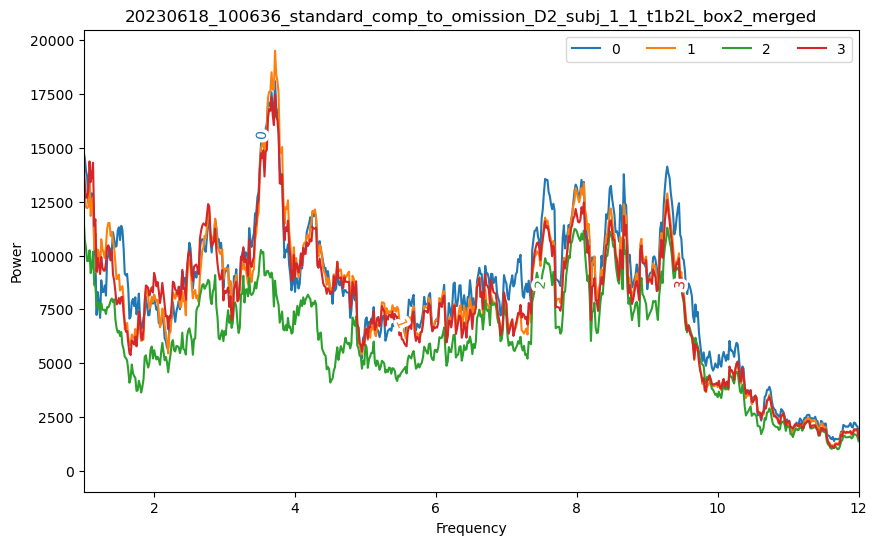

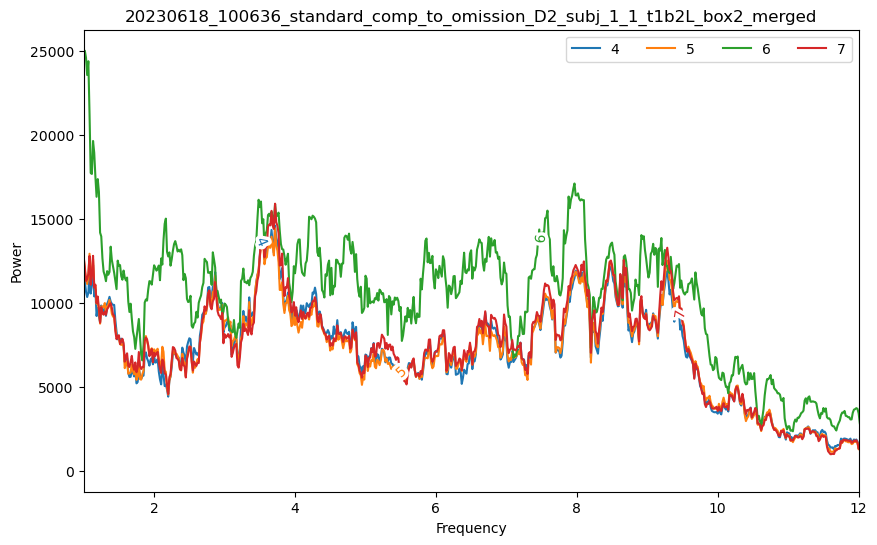

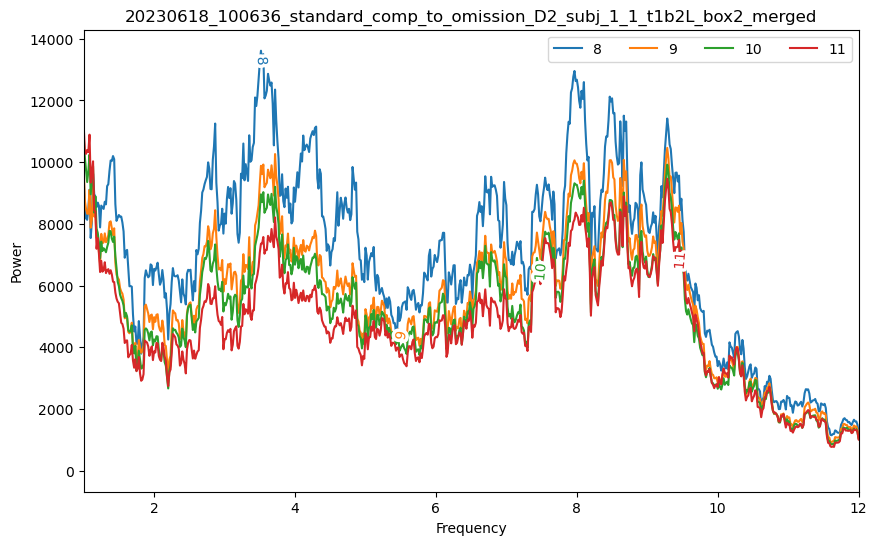

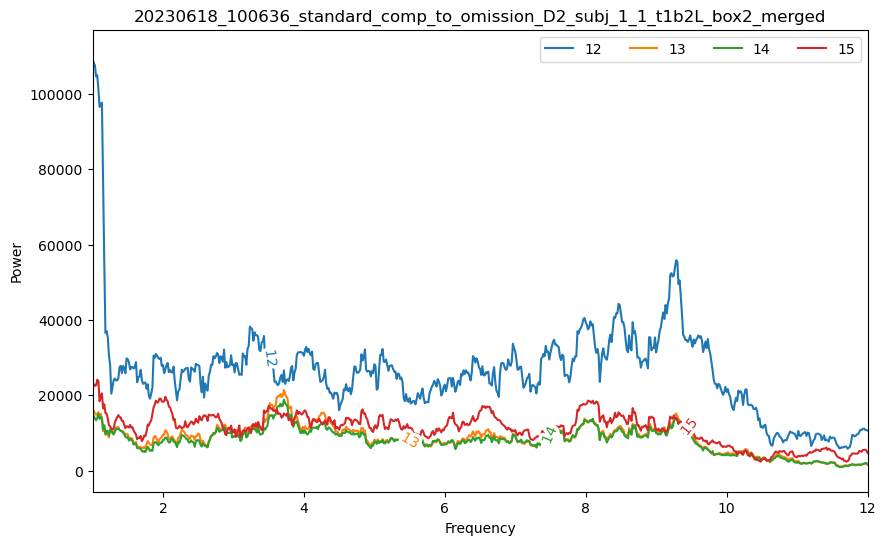

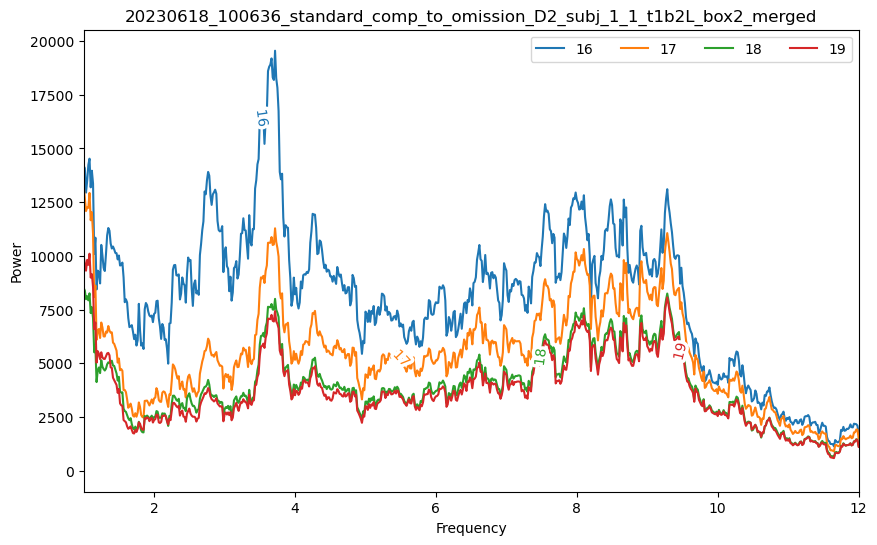

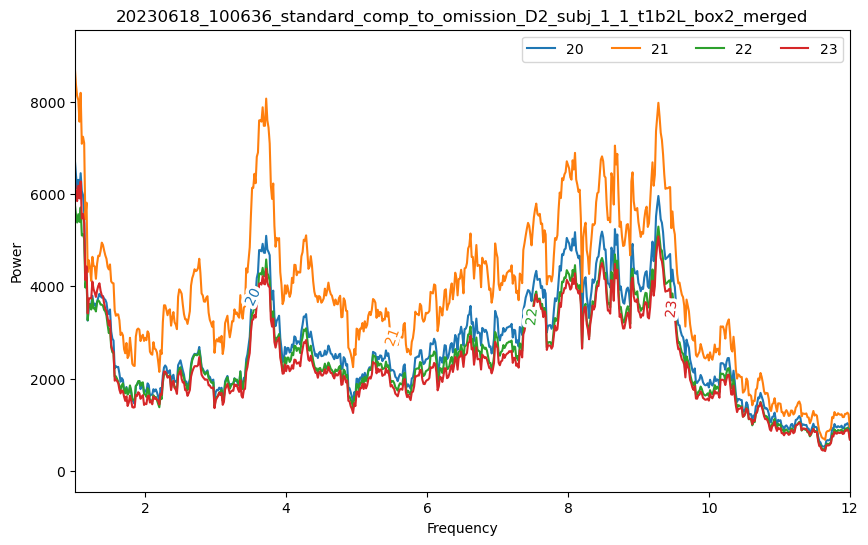

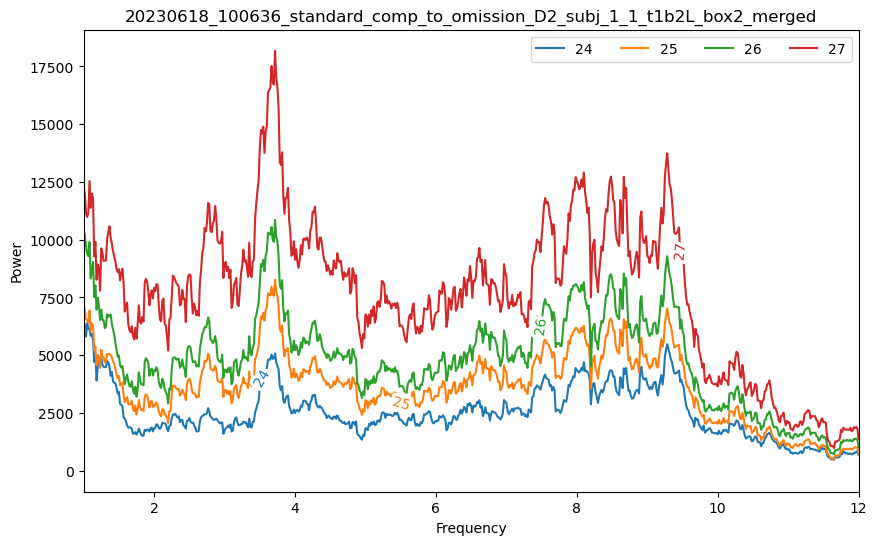

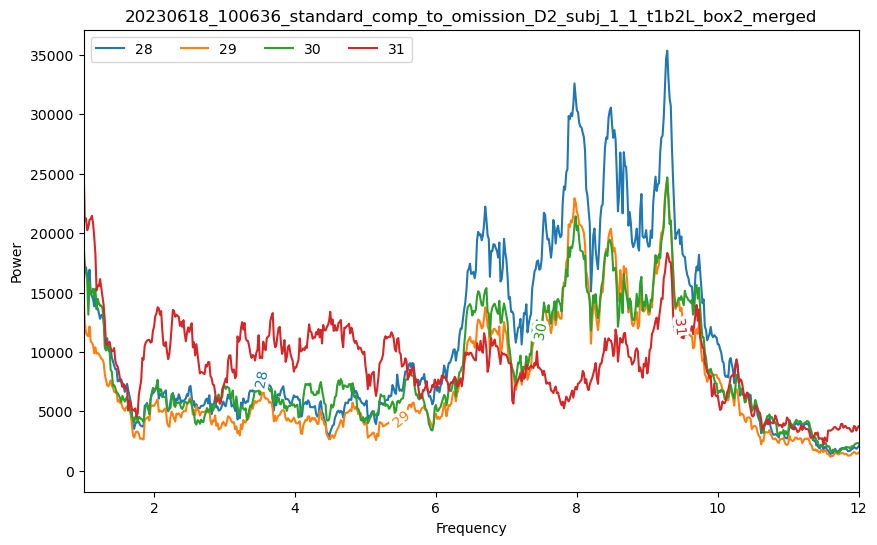

./proc/20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged/lfp_preprocessing


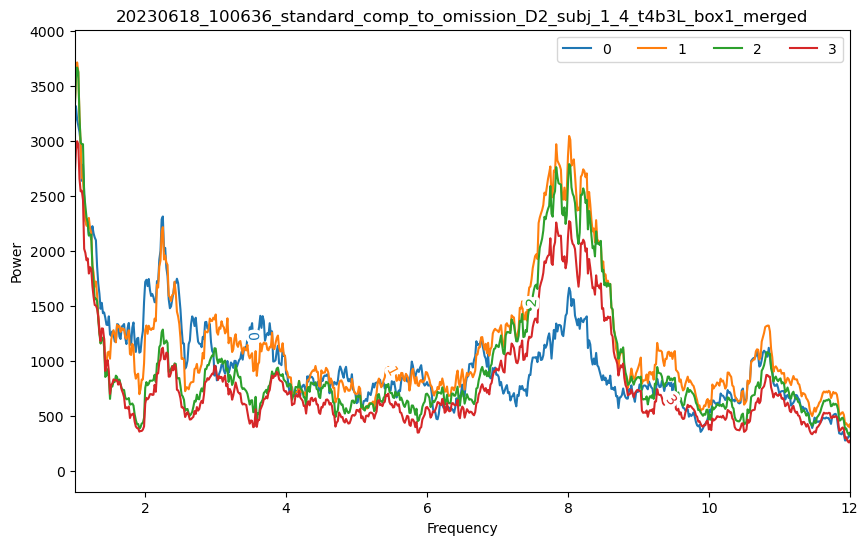

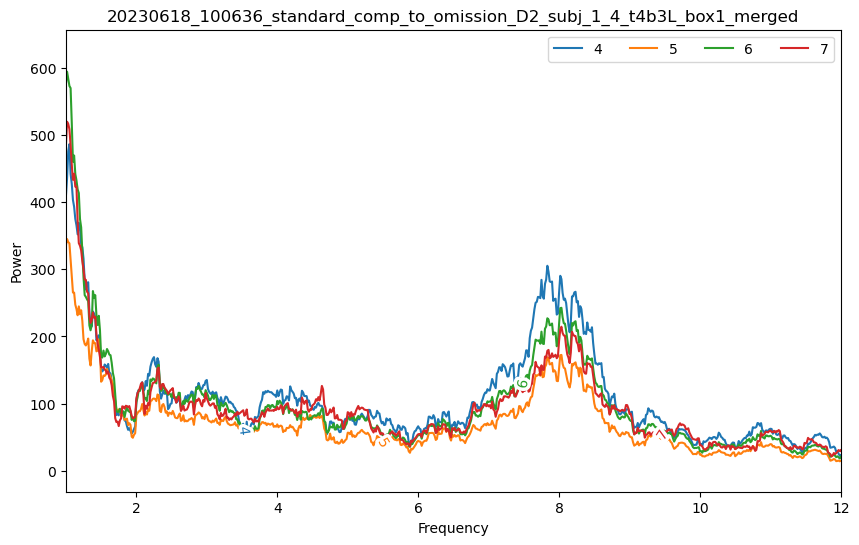

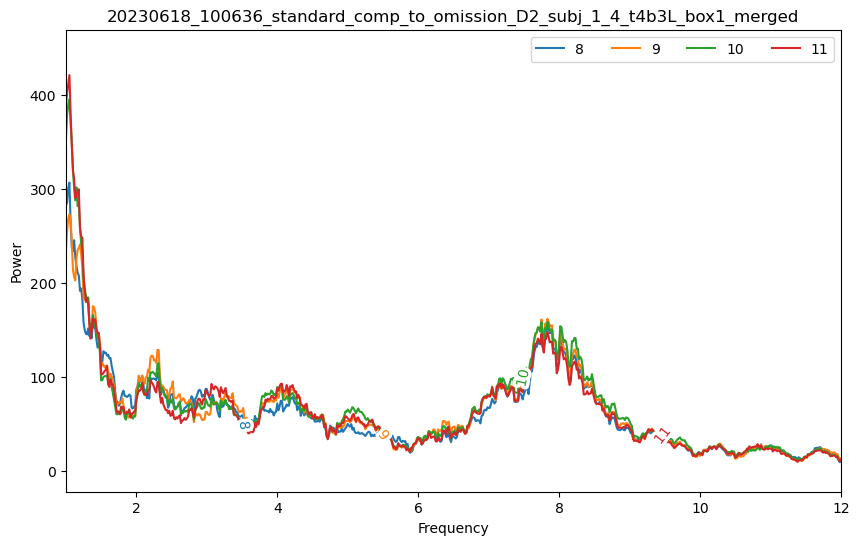

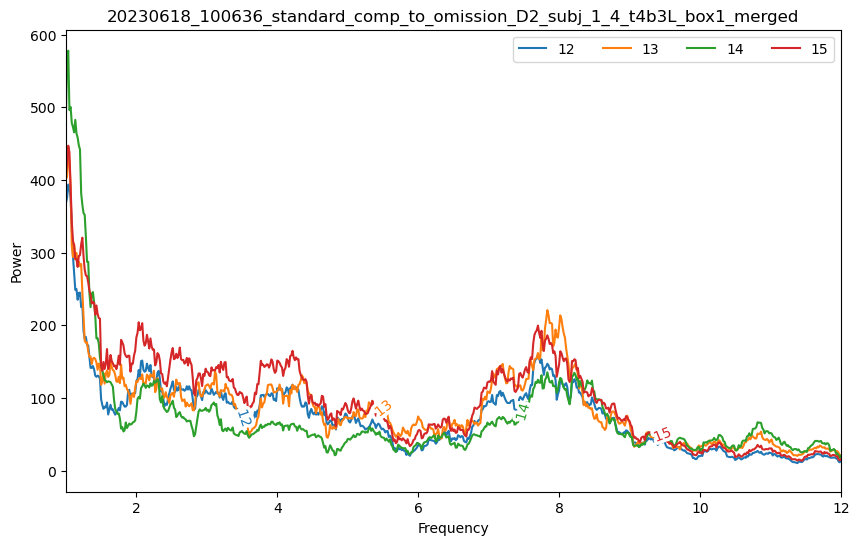

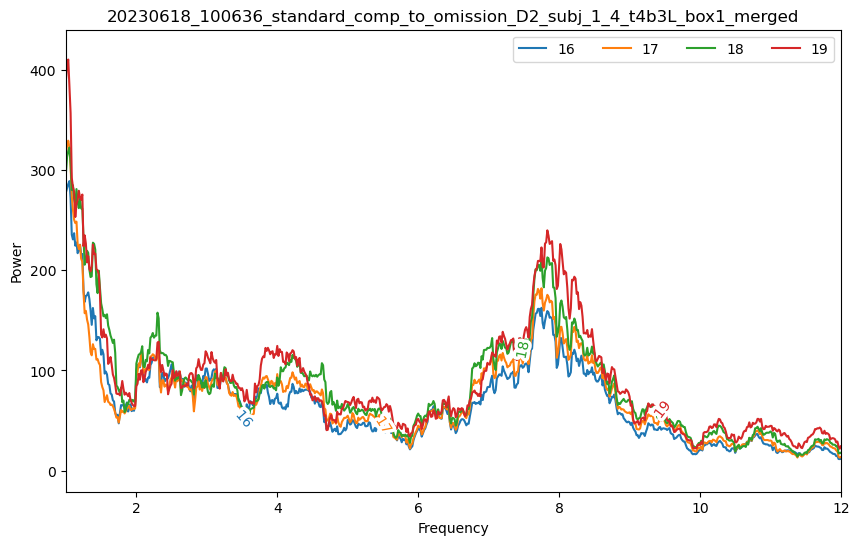

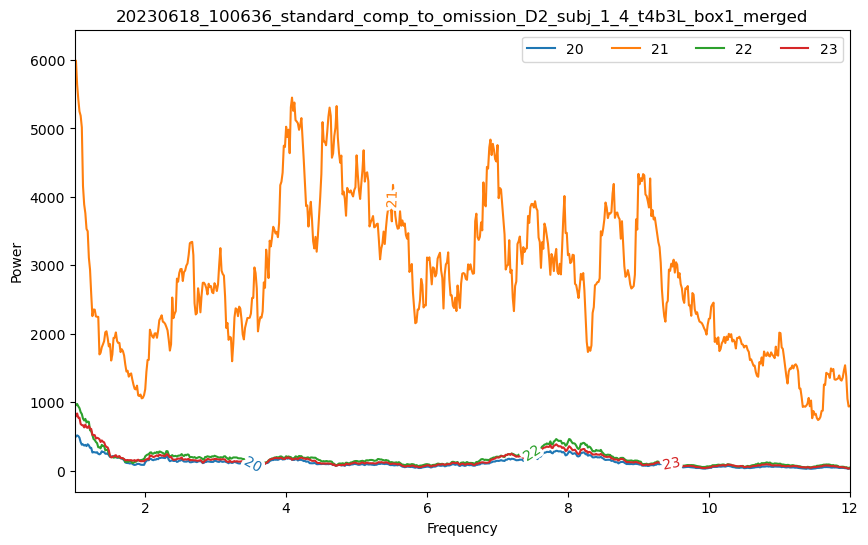

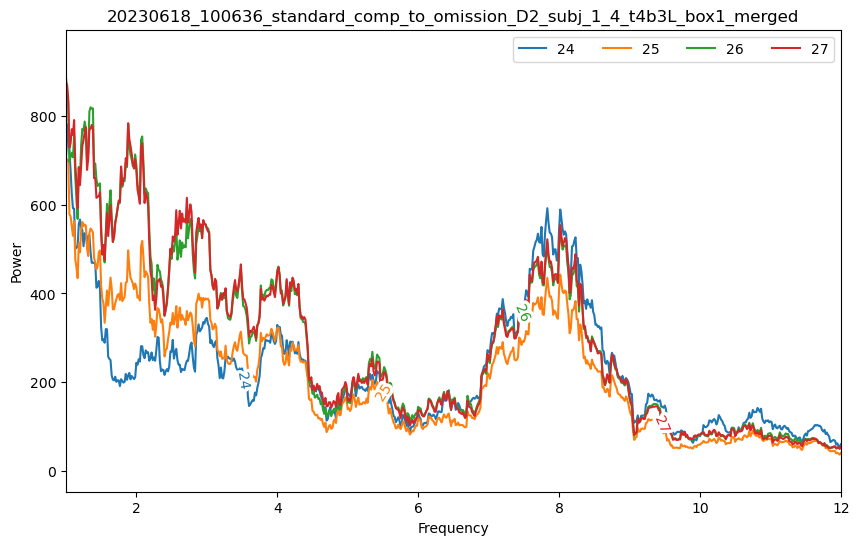

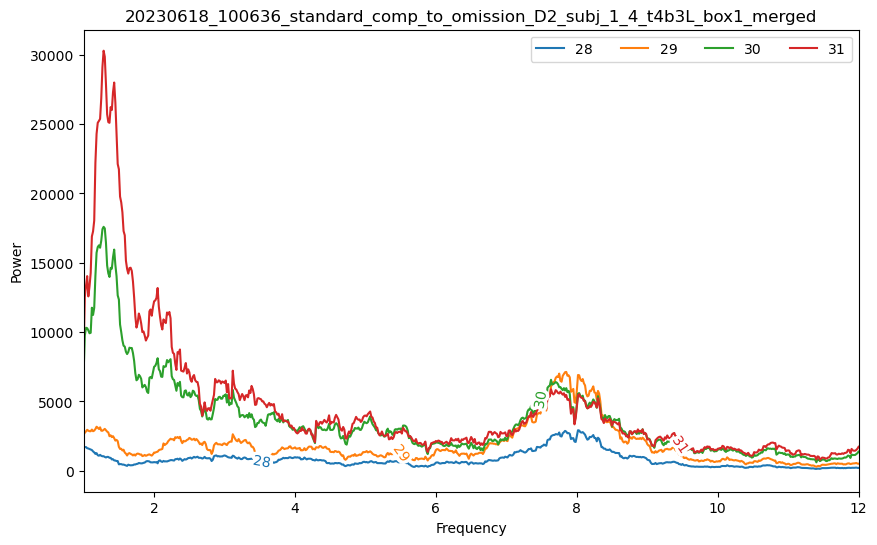

In [26]:
for preprocessed_lfp_path in lfp_preprocessing_filepath_glob:
    recording_basename = os.path.basename(os.path.dirname(recording_path))
    trodes_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
    preprocessed_recording = spikeinterface.preprocessing.bandpass_filter(trodes_recording, freq_min=0.5, freq_max=300)
    preprocessed_recording = spikeinterface.preprocessing.notch_filter(preprocessed_recording, freq=60)
    preprocessed_recording = spikeinterface.preprocessing.resample(preprocessed_recording, resample_rate=1000)


    
    traces = preprocessed_recording.get_traces(start_frame=start_frame*1000, end_frame=end_frame*1000)
    
    # Compute multitaper spectral estimate
    m = Multitaper(time_halfbandwidth_product=time_halfbandwidth_product, time_series=traces,
                   sampling_frequency=resampled_frequency)
    
    # Sets up computing connectivity measures/power from multitaper spectral estimate
    c = Connectivity.from_multitaper(m)
    
    for num in range(8):
        channels = [int(num) for num in recording_intermediate.channel_ids[num*4: num*4+4]]
        
    
    
        fig, ax = plt.subplots()
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Power")
        ax.plot(c.frequencies, c.power().squeeze()[:,channels], label=channels)
        ax.set_xlim(1,12)
        ax.legend(ncol=4)
        labelLines(ax.get_lines(), zorder=2.5)
        plt.title(recording_basename)
        os.makedirs('./proc/{}'.format(recording_basename), exist_ok=True)
        plt.savefig('./proc/{}/{}_ch_{}.png'.format(recording_basename, recording_basename, "-".join([str(ch) for ch in channels])))
        plt.show()


./proc/20230612_112630_standard_comp_to_training_D1_subj_1-1_t1b3L_box2_merged/lfp_preprocessing


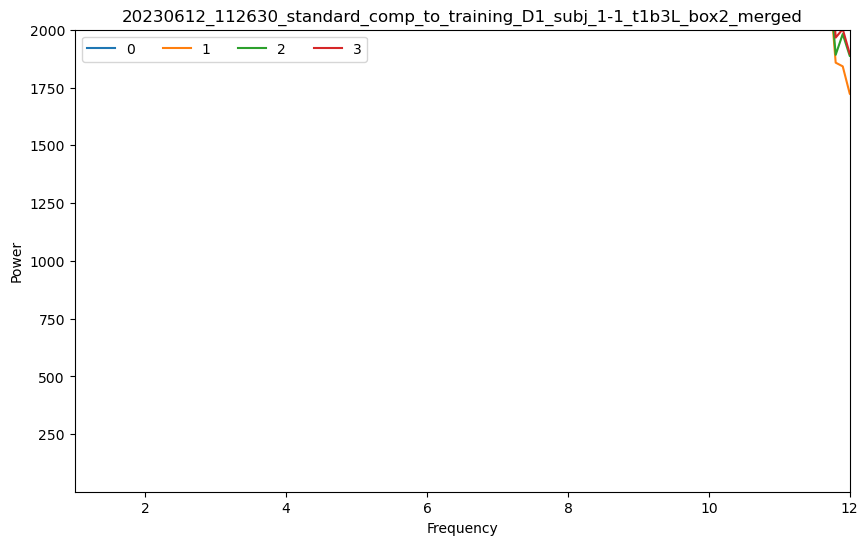

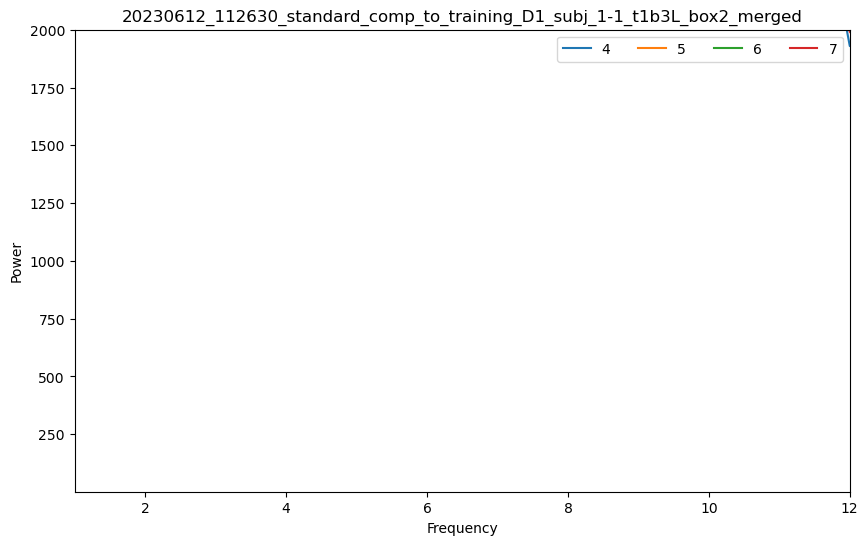

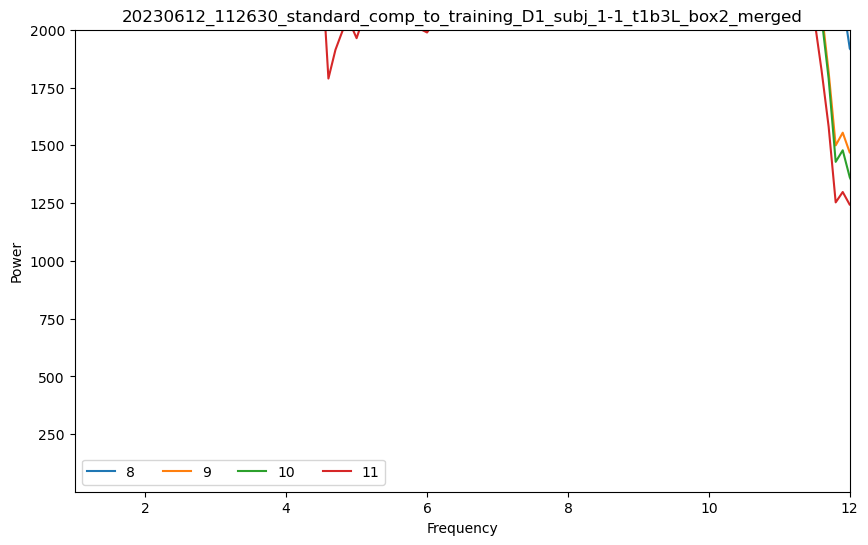

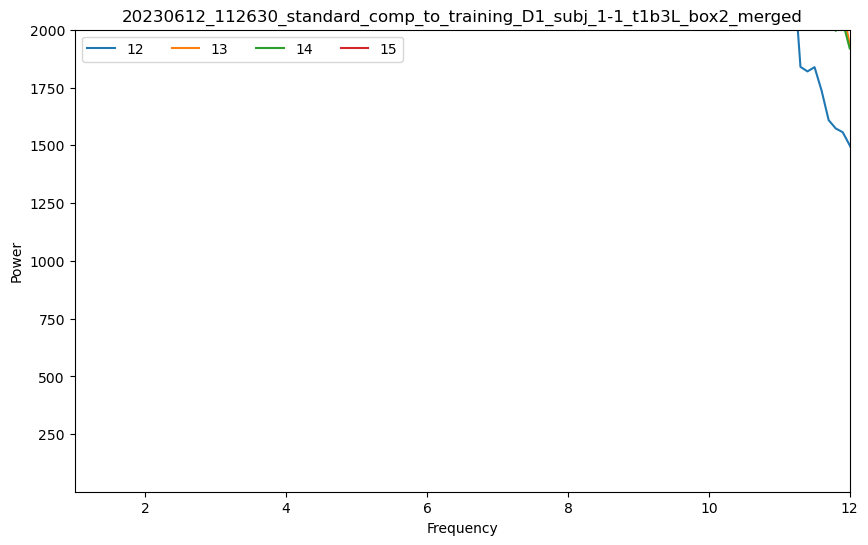

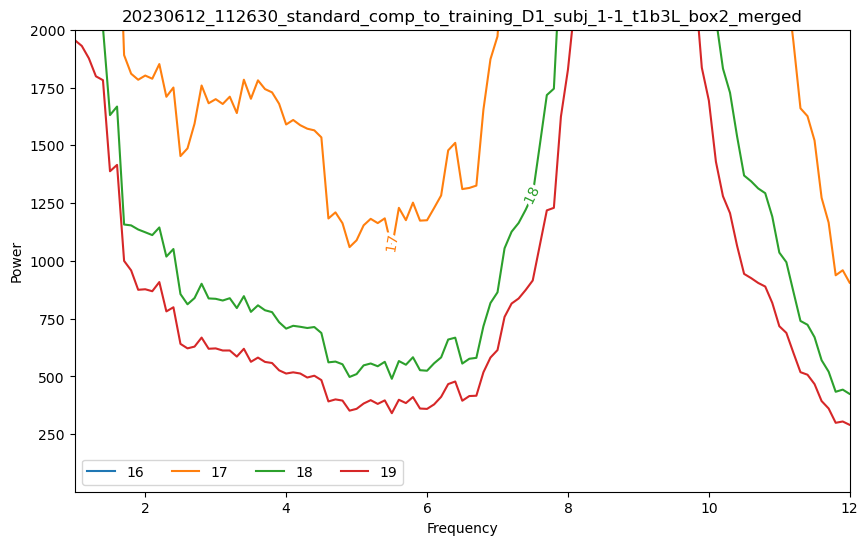

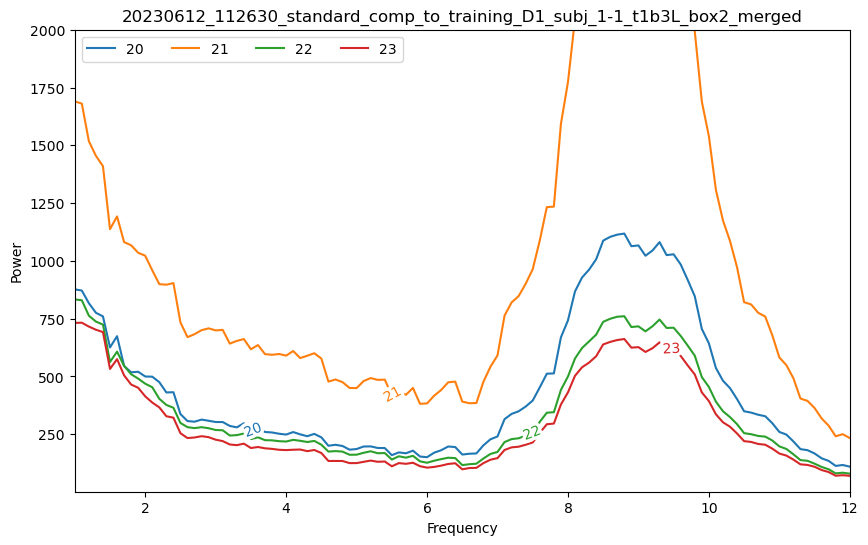

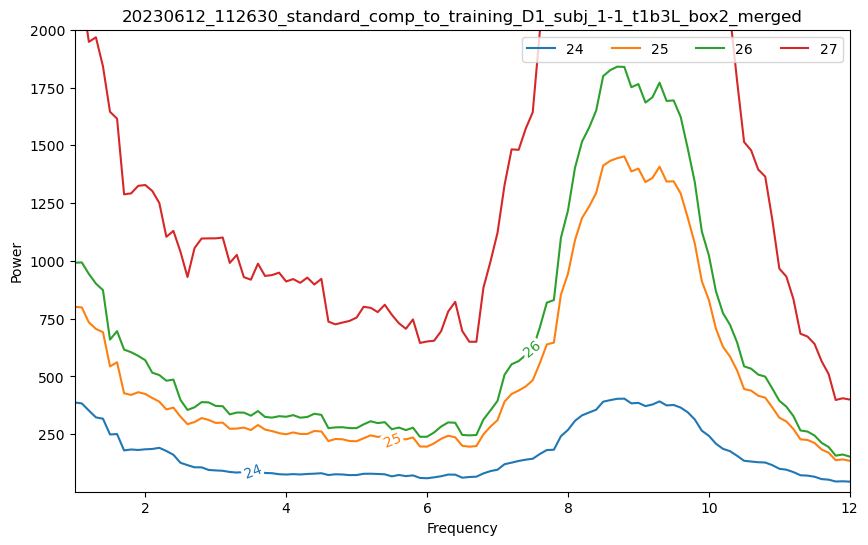

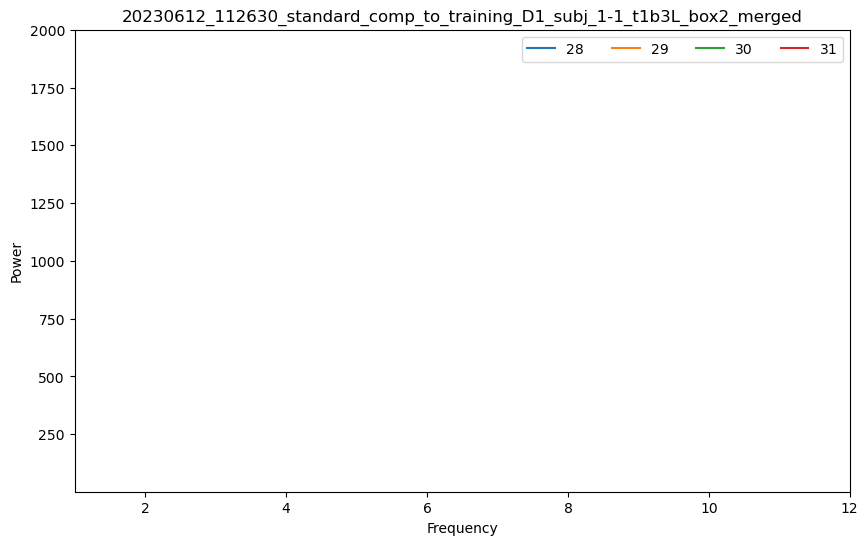

./proc/20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged/lfp_preprocessing


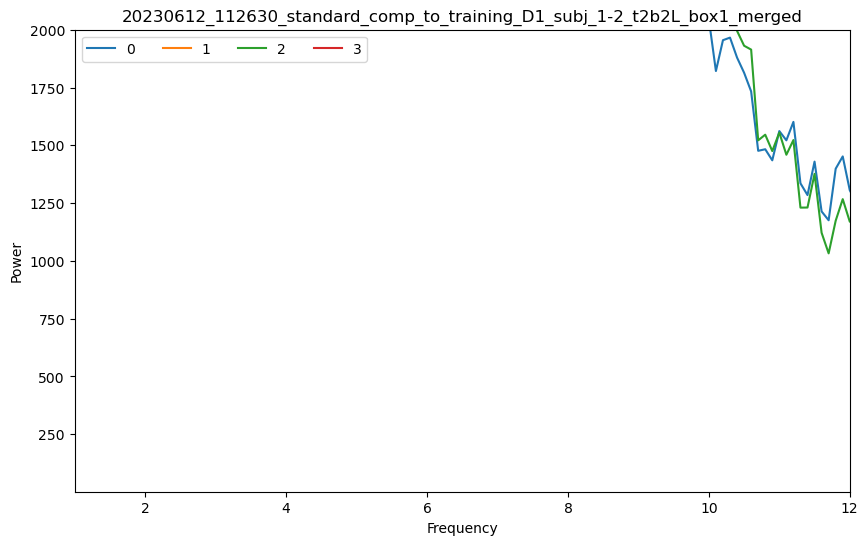

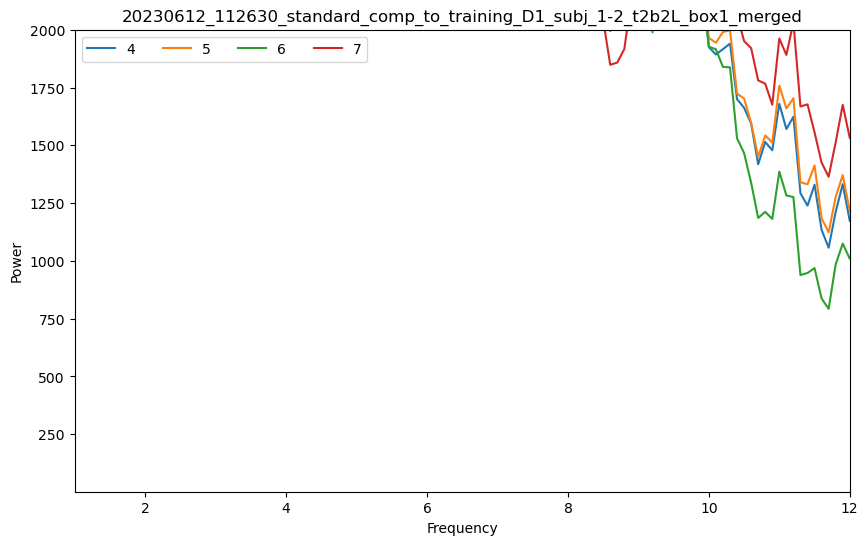

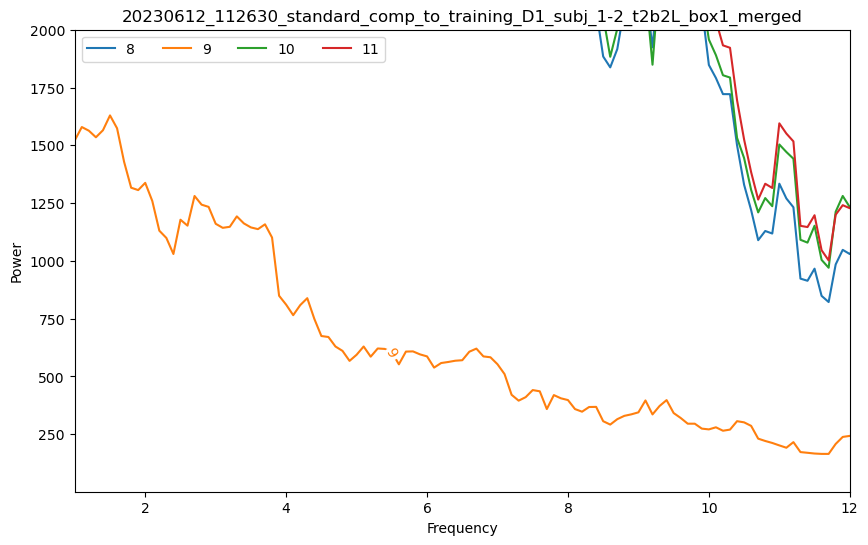

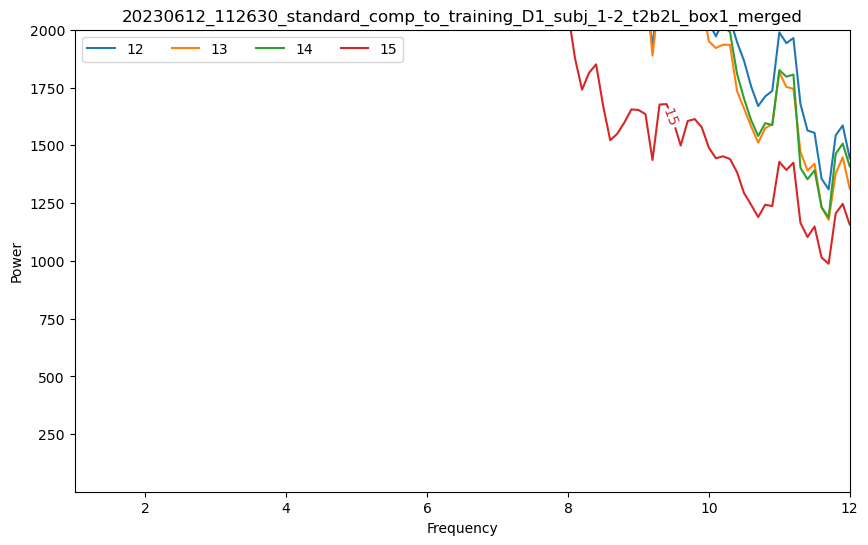

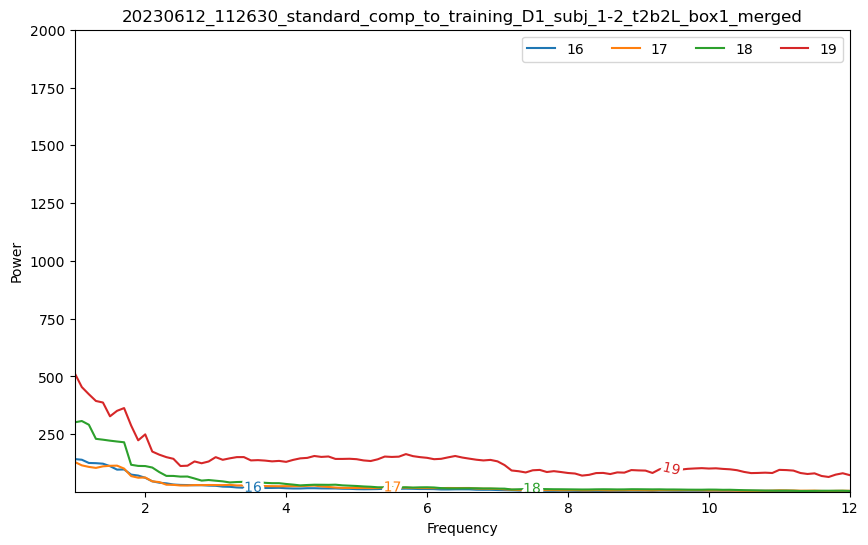

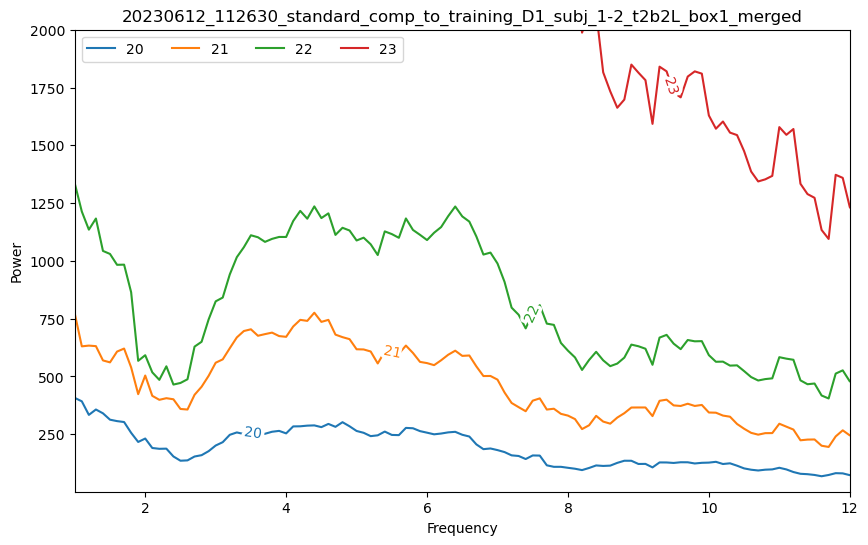

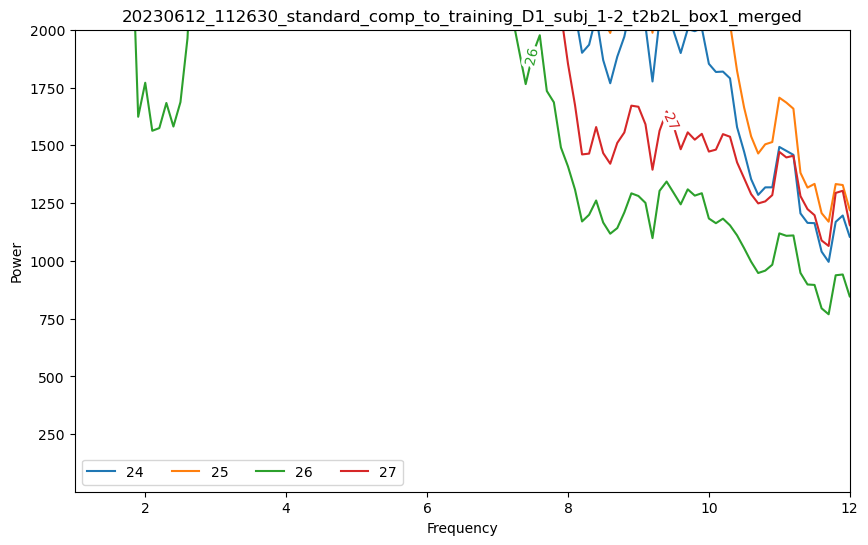

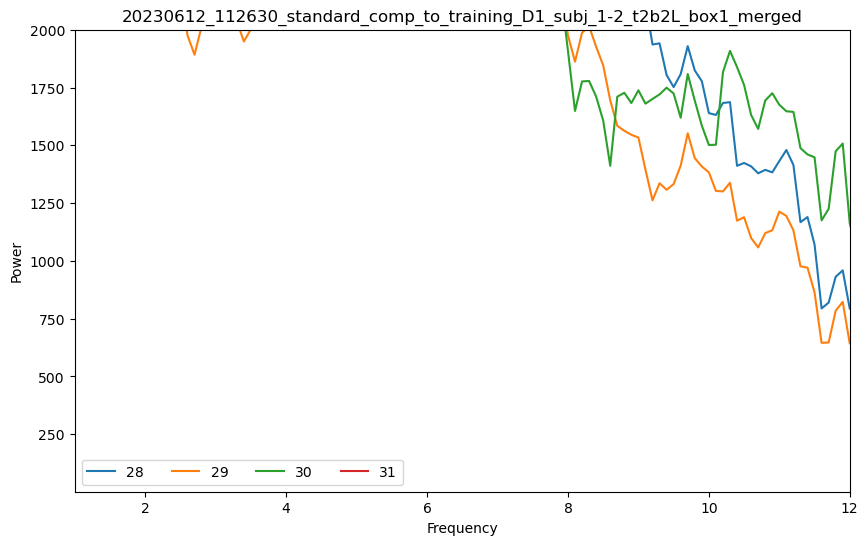

./proc/20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged/lfp_preprocessing


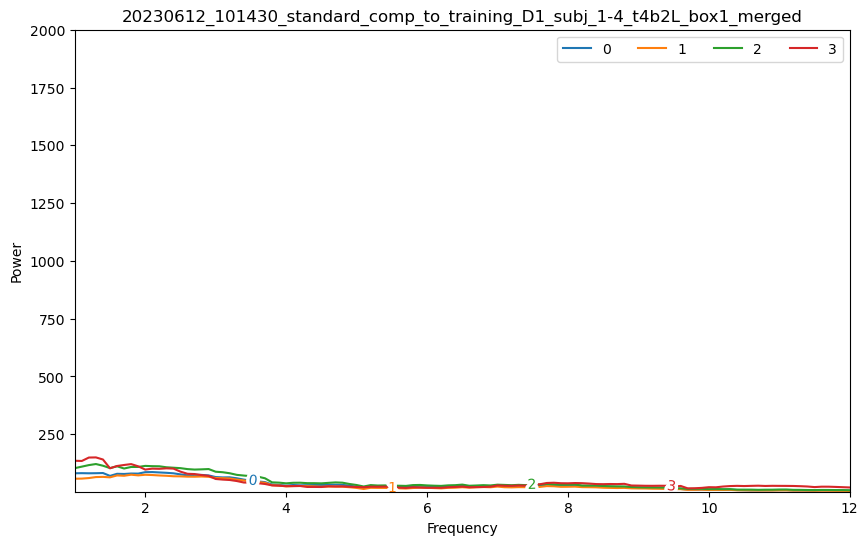

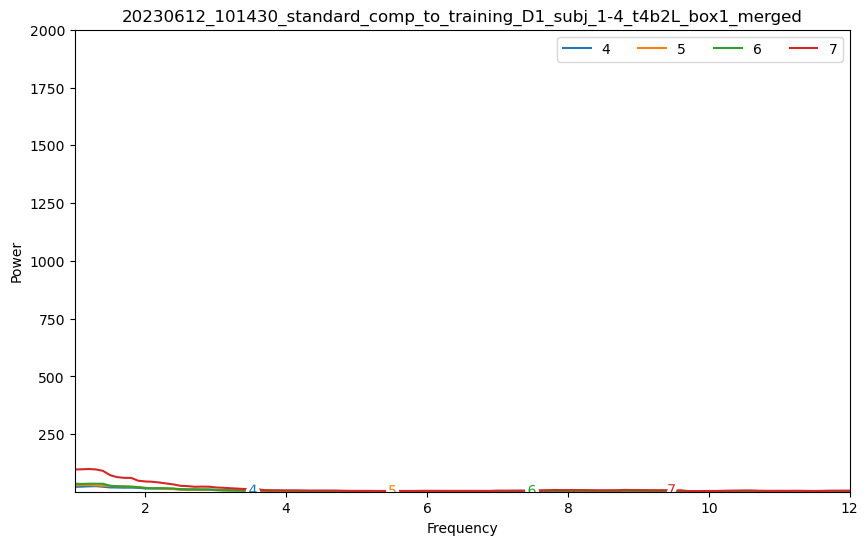

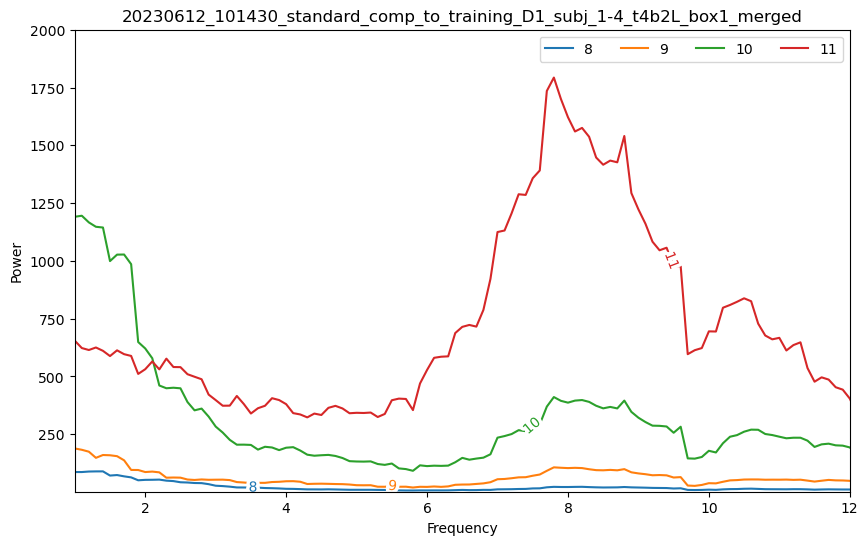

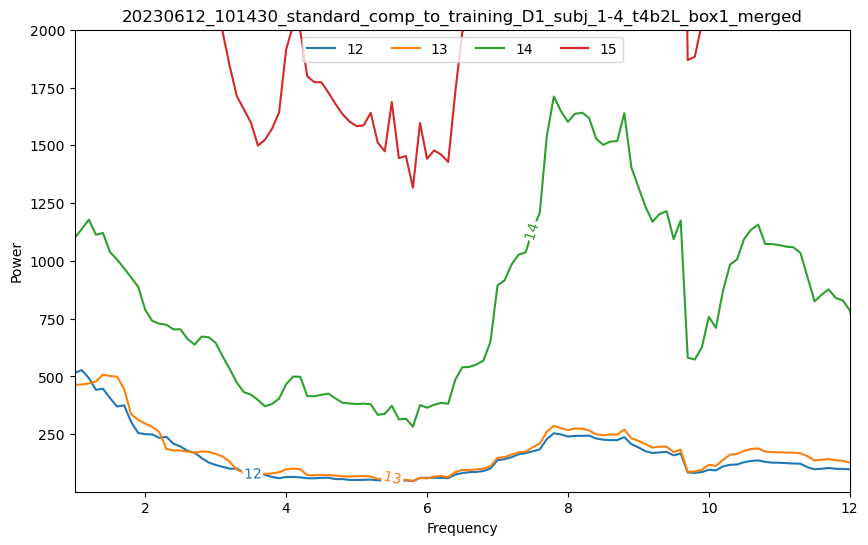

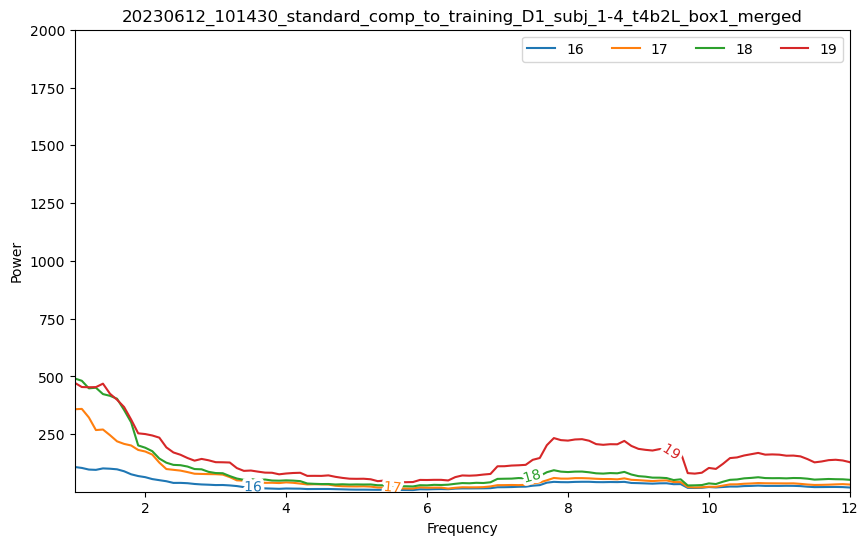

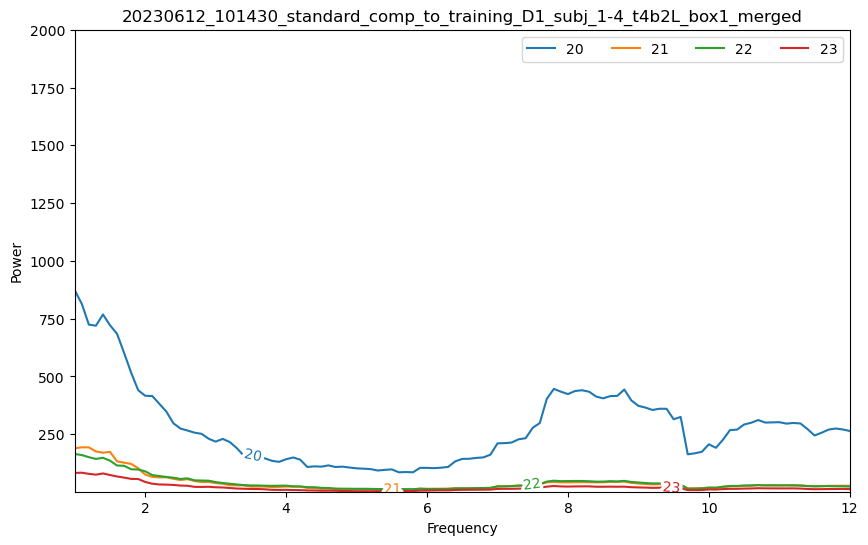

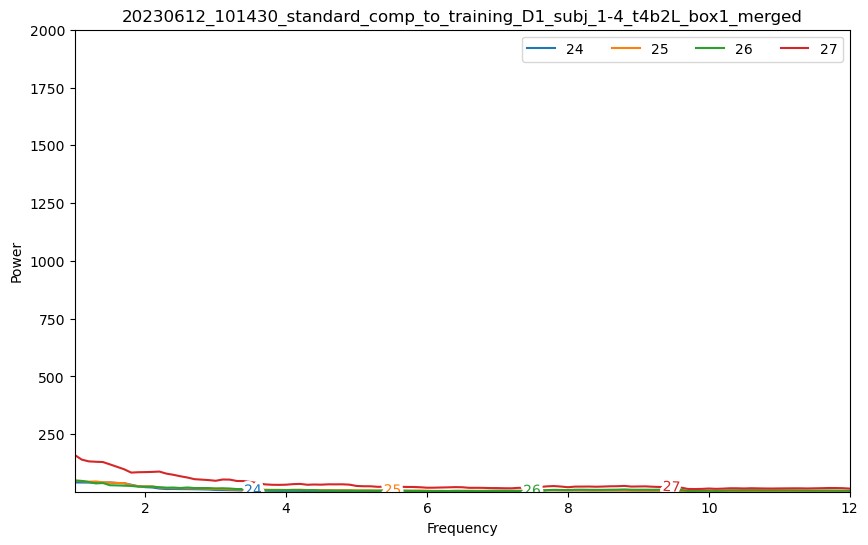

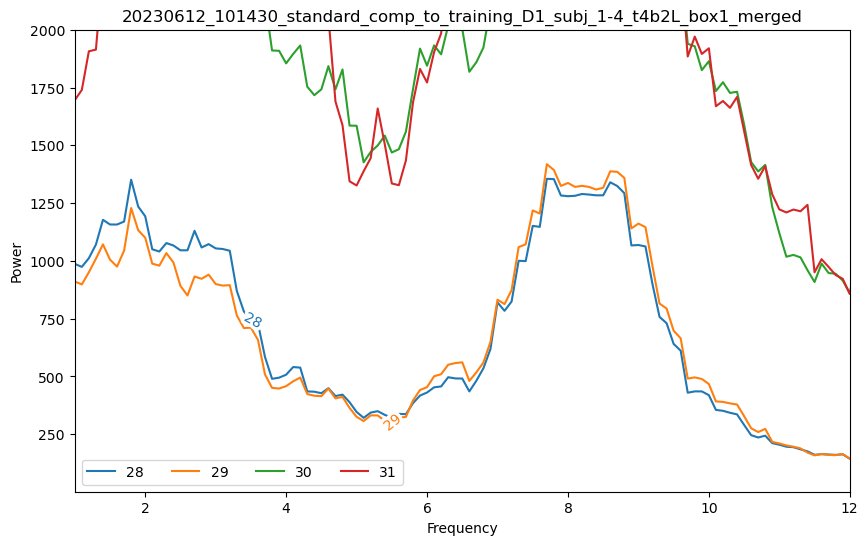

./proc/20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged/lfp_preprocessing


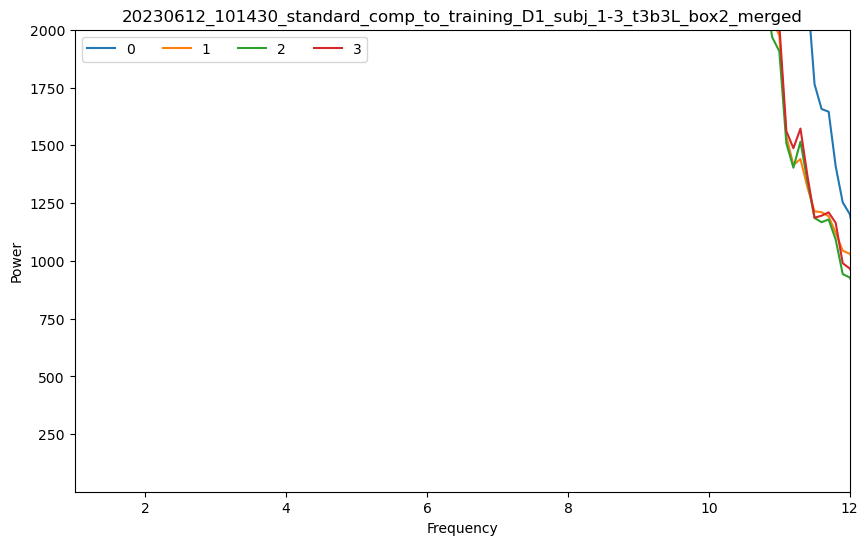

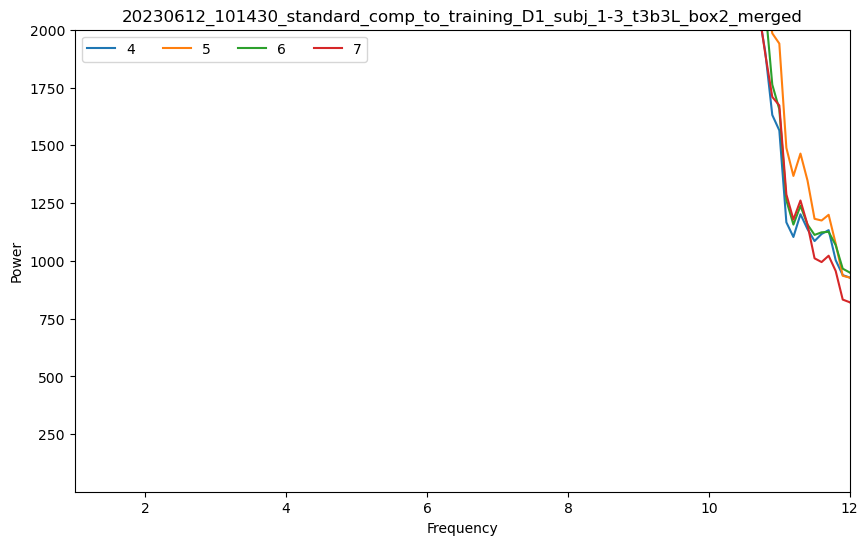

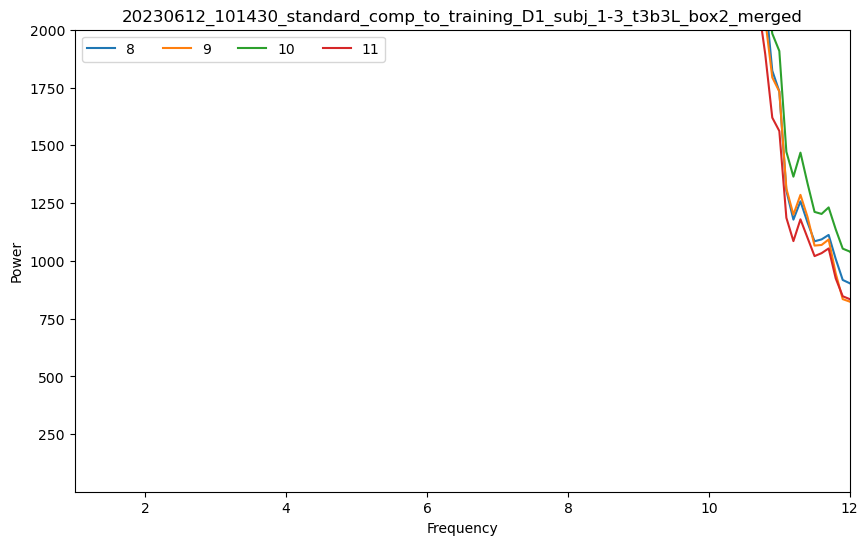

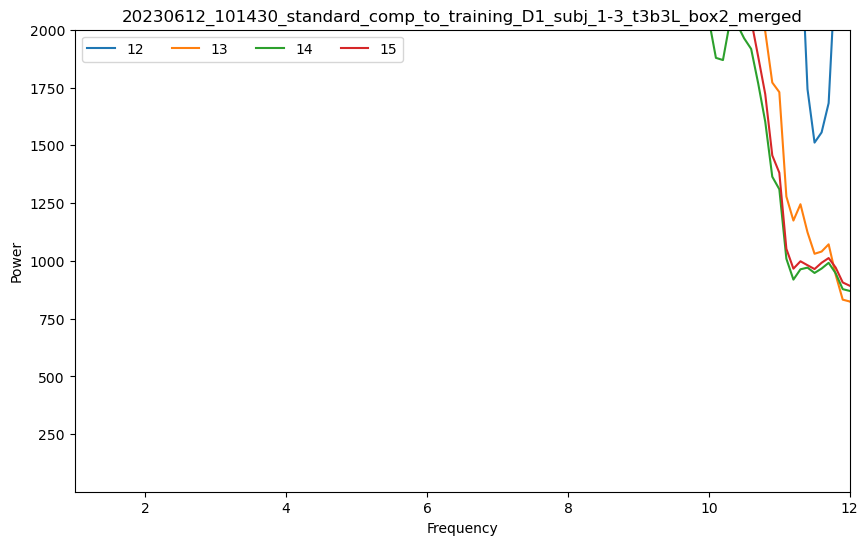

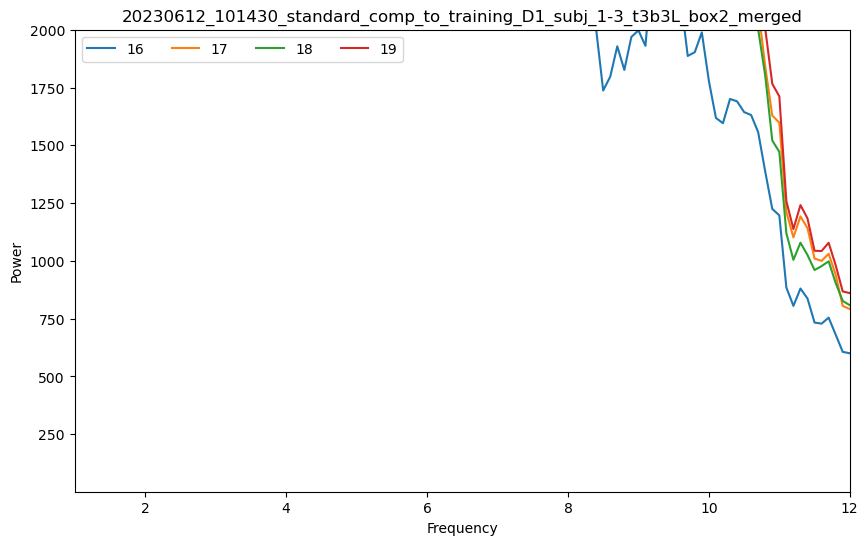

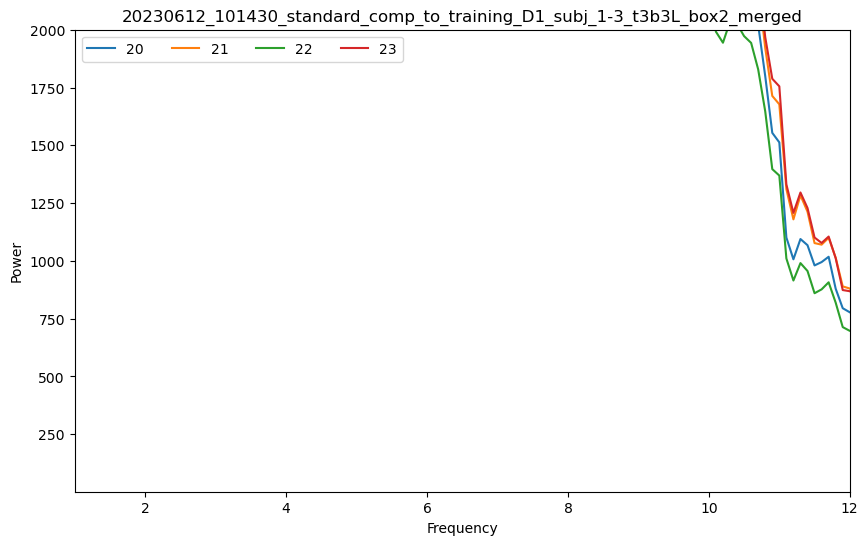

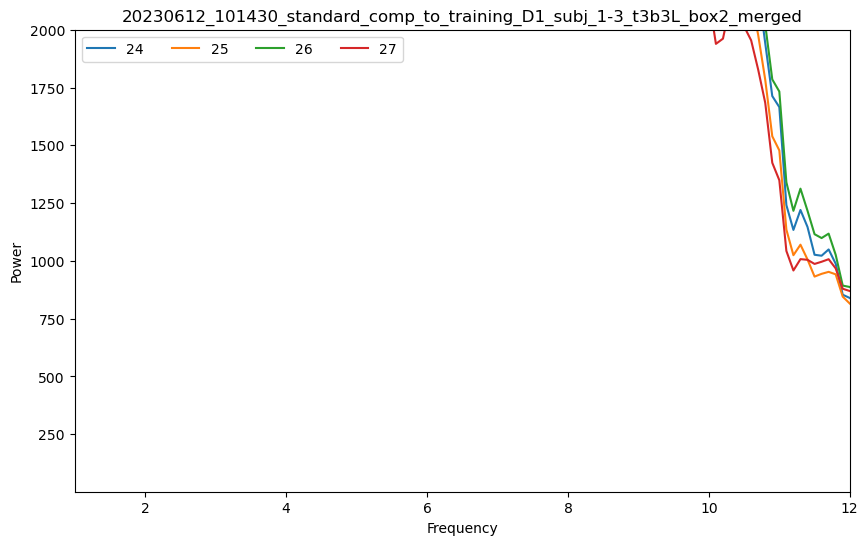

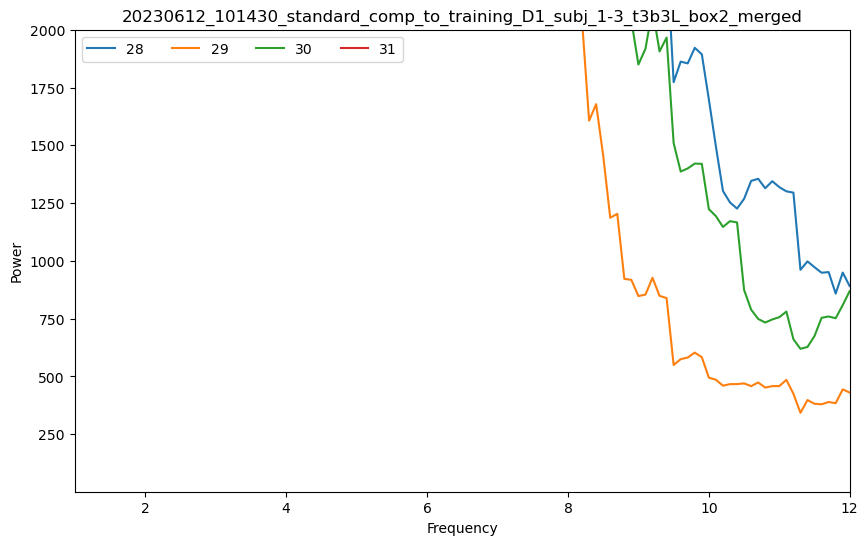

In [26]:
for preprocessed_lfp_path in lfp_preprocessing_filepath_glob:
    print(preprocessed_lfp_path)
    recording_intermediate = spikeinterface.core.load_extractor(file_or_folder_or_dict=preprocessed_lfp_path)
    recording_basename = os.path.basename(os.path.dirname(preprocessed_lfp_path))
    parent_output_directory = os.path.dirname(preprocessed_lfp_path)

    
    # Resampling
    recording_intermediate = spikeinterface.preprocessing.resample(recording_intermediate, resample_rate=resampled_frequency) 
#     sw.plot_timeseries(recording_intermediate, time_range=time_range, channel_ids=channel_ids, show_channel_ids=True)

    # Getting the traces
    
    traces = recording_intermediate.get_traces(start_frame=1000*1000, end_frame=1010*1000)
    
    # Compute multitaper spectral estimate
    m = Multitaper(time_halfbandwidth_product=time_halfbandwidth_product, time_series=traces,
                   sampling_frequency=resampled_frequency)
    
    # Sets up computing connectivity measures/power from multitaper spectral estimate
    c = Connectivity.from_multitaper(m)
    
    for num in range(8):
        channels = [int(num) for num in recording_intermediate.channel_ids[num*4: num*4+4]]
        
    
    
        fig, ax = plt.subplots()
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Power")
        ax.plot(c.frequencies, c.power().squeeze()[:,channels], label=channels)
        ax.set_xlim(1,12)
        ax.set_ylim(1,2000)

        ax.legend(ncol=4)
        labelLines(ax.get_lines(), zorder=2.5)
        plt.title(recording_basename)
        plt.show()


### Get all the traces

In [27]:
raise ValueError()

ValueError: 

In [ ]:
recording_root_to_everything = defaultdict(dict)

In [ ]:
resampled_frequency = 1000

In [ ]:
np_issue_files = []
for preprocessed_lfp_path in lfp_preprocessing_filepath_glob:
    try:
        print(preprocessed_lfp_path)
        recording_intermediate = spikeinterface.core.load_extractor(file_or_folder_or_dict=preprocessed_lfp_path)
        recording_basename = os.path.basename(os.path.dirname(preprocessed_lfp_path))
        parent_output_directory = os.path.dirname(preprocessed_lfp_path)

        # Resampling
        recording_intermediate = spikeinterface.preprocessing.resample(recording_intermediate, resample_rate=resampled_frequency) 

        # Getting the traces
        
        traces = recording_intermediate.get_traces(start_frame=0, end_frame=recording_intermediate.get_num_samples()-1)
        # Saving the trace to a Numpy file
        traces_filename = "{}.traces.npy".format(recording_basename)
        np.save(file=os.path.join(parent_output_directory, traces_filename), arr=traces)
    except:
        np_issue_files.append(preprocessed_lfp_path)